In [1]:
import math
import numpy as np
import random
from collections import defaultdict

from agent import *
from rl import *
from utils import *

Using TensorFlow backend.
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/david/.local/lib/python3.7/site-packages/

# Standard Maze

In [2]:
class MazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize, goal):
        super(MazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.__goal = goal
        
    def onBegin(self, state, startState = None):
        if startState() is not None:
            state(startState)
        else:
            state(random.randrange(self.__size))
        
    def onStep(self, state):
        if self.stepCount() > 0:
            self.reward(0.0, absorb=False)
        action = self.predict(f"s{state()}", ("left", "right"))
        if action == 0:
            state((state() - 1) % self.__size)
        else:
            state((state() + 1) % self.__size)
    
    def onFinish(self, state):
        if state() == self.__goal and self.stepCount() > 0:
            self.reward(1.0)
        return self.stepCount()
    
    def isAtGoal(self, state):
        return state() == self.__goal
    
    def plot(self, title):
        l, r = ([self.rl().maxValue(f"s{i}", a) for i in range(self.__size)] for a in ("left", "right"))
        plot(title, MAZE_SIZE, (l, r), ("Left", "Right"))

In [3]:
# Hard limit number of moves for a single episode
STEP_LIMIT = 100

In [4]:
# Maze Settings
MAZE_SIZE = 20
GOAL      = 10

# Agent Settings
HRR_SIZE   = 512 # 64
LEARN_RATE = 0.05
EPSILON    = 0.2
DISCOUNT   = 0.75

# The agents (Q-learning, double Q-learning, deep Q-learning, double/deep Q-learning)
ql = NQLearningNetwork(1, HRR_SIZE, learnRate=LEARN_RATE, discountFactor=DISCOUNT)
agent = MazeAgent(ql, MAZE_SIZE, GOAL)

Time: 1.89 seconds
Episode: 9
Error: -1
Progress: [####################] 100.00%


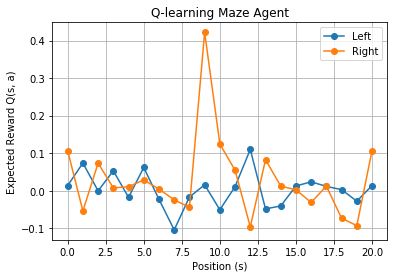

In [5]:
train("Q-learning Maze Agent", agent, maxEpochs=2000, epsilon=EPSILON, simLimit=STEP_LIMIT)

# n-Task Maze

In [86]:
def logTransform(delta):
    return np.sign(delta)*np.log(abs(delta) + 1)

def plotFrames(title, *frameGroups, labels):
    fig, ax = plt.subplots()
    for i, group in enumerate(frameGroups):
        keys = tuple(group.keys())
        t = np.arange(keys[0], keys[-1] + 1, 1)
        ax.plot(t, list(group.values()), label=labels[i])
    ax.set(xlabel='Episode', ylabel='Value', title=title)
    ax.grid()
    plt.legend()
    

In [87]:
class NTaskMazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize, goals):
        super(NTaskMazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.__goals = goals
        self.__rewardValue = HolographicNeuralNetwork(self.rl().hrrSize(), 1) # Learns the value function for the reward schedule
        self.__atrFrames = defaultdict(dict)
        self.__thresholdFrames = {}
        self.initNTask(len(goals))
        
    def initNTask(self, nGoals):
        """Initialize the ATR values and threshold value"""
        self.__atrValues = [1.0] * nGoals # Abstract task representation lookup values (optimistic)
        self.__threshold = -1.0 # negative of goal reward value
        self.trackFrames()
        
    def onBegin(self, state, wm, goal, startState = None):
        """Set everything up at the beginning of the episode"""
        if goal() is None:
            goal(len(self.__goals) - 1) # Initialize the goal
        if wm() is None:
            wm(0) # Use the first ATR
        if startState() is not None:
            state(startState)
        else:
            state(random.randrange(self.__size))
            
        # Switch to the next goal every 100 episodes
#         if self.episode() % 100 == 0:
#             goal((goal() + 1) % len(self.__goals)) # Change to the next goal position
#             print("Episode switch")
        
    def onStep(self, state, wm, goal):
        """Each step within the episode"""
        if self.stepCount() > 0:
            self.reward(0.0, state, goal, absorb=False)
        action = self.predict(self.stateConvolution(state, wm), ("left", "right"))
        if action == 0:
            state((state() - 1) % self.__size)
        else:
            state((state() + 1) % self.__size)
    
    def onFinish(self, state, wm, goal):
        """At the end of the episode, give out a reward (if necessary)"""
        if self.stepCount() > 0 and self.isAtGoal(state, goal):
            self.reward(1.0, state, wm)
        self.trackFrames()
        return self.stepCount()
    
    def isAtGoal(self, state, goal):
        """Check if the agent has reached the current goal state"""
        return state() == self.__goals[goal()]
    
    # This currently doesn't work well when reaching an unexpected goal
    def reward(self, reward, state, wm, absorb=True):
        """Give a reward to the agent"""
        
        # Check if we should task switch
        delta = reward - (self.__rewardValue.value(self.stateConvolution(state, wm))[0] + 1)
        if delta < self.__threshold:
#             wm((wm() + 1) % len(self.__atrs)) # Try the next ATR
#             print("Task switched")
            return
        
        # No task switch occurred, learn the reward
        super(NTaskMazeAgent, self).reward(reward, absorb=absorb)
        self.__rewardValue.fit(self.stateConvolution(state, wm), [reward - 1])
        self.__threshold -= 1.0*delta
        
        # If we are at a goal/terminating state, update the threshold and ATR value
        if absorb: # If at a goal/terminating state
            self.__atrValues[wm()] += 1.0*logTransform(reward - self.__atrValues[wm()])
            
    def stateConvolution(self, state = None, wm = None):
        if type(state) != int:
            state = state()
        if type(wm) != int:
            wm = wm()
        return f"s{state}*atr{wm}"
    
    def trackFrames(self):
        """Log the current ATR and threshold values for plotting"""
        for i, atrValue in enumerate(self.__atrValues):
            self.__atrFrames[i][self.episode()] = atrValue
        self.__thresholdFrames[self.episode()] = self.__threshold
    
    def plot(self, title):
        rewardValues = []
        for atr in range(len(self.__atrValues)):
            rewardValues.append([self.__rewardValue.value(self.stateConvolution(i, atr))[0]+1 for i in range(self.__size)])
            l, r = ([self.rl().maxValue(self.stateConvolution(i, atr), a) for i in range(self.__size)] for a in ("left", "right"))
            plot(f"{title} - ATR {atr}", MAZE_SIZE, (l, r), ("Left", "Right"))
        plot(f"{title} - Reward Value Function", MAZE_SIZE, rewardValues, [f"ATR: {g}" for g in self.__goals])
        plotFrames(f"{title} - Threshold", self.__thresholdFrames, labels=("t",))
        

In [88]:
# Hard limit number of moves for a single episode
STEP_LIMIT = 100

In [89]:
# Maze Settings
MAZE_SIZE = 20
GOALS     = (0, 10) 

# Agent Settings
HRR_SIZE   = 512 # 64
LEARN_RATE = 0.05
EPSILON    = 0.2
DISCOUNT   = 0.75

# The agents (Q-learning, double Q-learning, deep Q-learning, double/deep Q-learning)
ql = NQLearningNetwork(1, HRR_SIZE, learnRate=LEARN_RATE, discountFactor=DISCOUNT)
agent = NTaskMazeAgent(ql, MAZE_SIZE, GOALS)

In [ ]:
train("Q-learning Maze Agent", agent, maxEpisodes=2000, epsilon=EPSILON, simLimit=STEP_LIMIT)

Time: 55.36 seconds
Episode: 1824
Error: -1
Progress: [##################--] 91.20%
